## link to the article that i used it's dataset : doi.org/10.1021/acs.joc.8b02270

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import ensemble
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, matthews_corrcoef, recall_score, confusion_matrix, ConfusionMatrixDisplay
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("https://raw.githubusercontent.com/Ianiusha/AutoLSF/master/EAS/my_training_data.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/Ianiusha/AutoLSF/master/EAS/my_external_test_data.csv")
X = train_data.iloc[:, 2:8].values
Y = train_data.iloc[:, 8].values
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1) 
X_res, y_res = rus.fit_resample(X, Y)
X_test_ext = test_data.iloc[:, 2:8].values
y_test_ext = test_data.iloc[:, 8].values

# Helping Functions

In [3]:
def calc_metrics(y_true, y_score, threshold = 0.5):
    y_score = y_score > threshold
    accuracy = accuracy_score(y_true, y_score)
    f1 = f1_score(y_true, y_score)
    mcc = matthews_corrcoef(y_true, y_score)
    precision = precision_score(y_true, y_score)
    recall = recall_score(y_true, y_score)
    matrix = confusion_matrix(y_true, y_score).ravel()
    return accuracy, f1, mcc, precision, recall, matrix
    
def confusion_matrix_(clf, x_test, y):
    predicted_test = clf.predict(x_test)
    cm = confusion_matrix(y, predicted_test)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Unactive site','Active site'])
    return cmd.plot()
def classification_report(y_test, y_pred):
    print(metrics.classification_report(y_test, y_pred))
    
def plt_roc_curve(clf, X, Y, x, y, name):
    predicted_training = clf.predict_proba(X)
    predicted_test = clf.predict_proba(x)
    fpr_test, tpr_test, _ = roc_curve(y, predicted_test[:,1])
    
    fpr_training, tpr_training, _ = roc_curve(Y, predicted_training[:,1])
    roc_training = roc_auc_score(Y, predicted_training[:,1])
    roc_test = roc_auc_score(y, predicted_test[:,1])
  
    accuracy, f1, mcc, precision, recall, matrix = calc_metrics(y, predicted_test[:,1])
    print(name, accuracy, precision, recall, f1, mcc, matrix)
    print()
    plt.figure()
    
    plt.rcParams.update({'font.size': 15})
    lw = 2
    plt.plot(fpr_training, tpr_training, color='blue',
             lw=lw, label='Training Set ROC AUC = %0.2f' % roc_training)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='Test Set ROC AUC = %0.2f' % roc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.005, 1.0])
    plt.ylim([-0.005, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# HYPEROPT

In [7]:
def data_pros(x_train, Y_train, x_test, Y_test):
        trans = StandardScaler()
        X_train = trans.fit_transform(x_train)
        y_train =(Y_train)
        X_test = trans.transform(x_test)
        y_test =(Y_test)
        return X_train, y_train, X_test, y_test

def space(max_depth, n_estimators, max_leaf_nodes):
        space={'max_depth': hp.quniform("max_depth",max_depth[0], max_depth[1], 1),
        'n_estimators': hp.quniform("n_estimators", n_estimators[0], n_estimators[1], 1),
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
        "max_features": hp.choice("max_features", ["auto", "sqrt", "log2"]),
        "max_leaf_nodes": hp.quniform("max_leaf_nodes", max_leaf_nodes[0], max_leaf_nodes[1], 1),
        "bootstrap": hp.choice("bootstrap", ["True", "False"]),
        "warm_start": hp.choice("warm_start", ["True", "False"])
         }
        return space


def object(space):

        model = ExtraTreesClassifier(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), criterion=space["criterion"],
                                     max_features=space["max_features"], max_leaf_nodes = int(space["max_leaf_nodes"]))
        evaluation = [( data[0],  data[1]), ( data[2], data[3])]
                
        model.fit(data[0],  data[1])

        pred = model.predict(data[2])
        accuracy = metrics.accuracy_score(data[3], pred)
        print ("SCORE:", accuracy)
        #change the metric if you like
        return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}
def train(max_evals, space):
        trials = Trials()
        best = fmin(fn=object,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=max_evals,
                        trials=trials, verbose=2)
        print (best)


In [8]:
data = data_pros(X_res, y_res, X_test_ext, y_test_ext)
space_n = space((20, 100), (10, 3000), (1, 1000))
train(400, space_n)

SCORE:
0.8411214953271028
SCORE:
0.8434579439252337
SCORE:
0.8341121495327103
SCORE:
0.8411214953271028
SCORE:
0.8411214953271028
SCORE:
0.8411214953271028
SCORE:
0.8317757009345794
SCORE:
0.8271028037383178
SCORE:
0.8341121495327103
SCORE:
0.8364485981308412
SCORE:
0.8317757009345794
SCORE:
0.8317757009345794
SCORE:
0.8364485981308412
SCORE:
0.8364485981308412
SCORE:
0.8317757009345794
SCORE:
0.8364485981308412
SCORE:
0.8294392523364486
SCORE:
0.8294392523364486
SCORE:
0.8387850467289719
SCORE:
0.8364485981308412
SCORE:
0.8341121495327103
SCORE:
0.8411214953271028
SCORE:
0.8387850467289719
SCORE:
0.8411214953271028
SCORE:
0.8247663551401869
SCORE:
0.8411214953271028
SCORE:
0.8317757009345794
SCORE:
0.8387850467289719
SCORE:
0.8364485981308412
SCORE:
0.8341121495327103
SCORE:
0.8481308411214953
SCORE:
0.8364485981308412
SCORE:
0.8341121495327103
SCORE:
0.8387850467289719
SCORE:
0.8341121495327103
SCORE:
0.8387850467289719
SCORE:
0.8457943925233645
SCORE:
0.8387850467289719
SCORE:
0.841

# Build the model and getting the plots

ExtraTreesClassifier 0.8621495327102804 0.6788321167883211 0.8611111111111112 0.7591836734693878 0.67372911505831 [276  44  15  93]



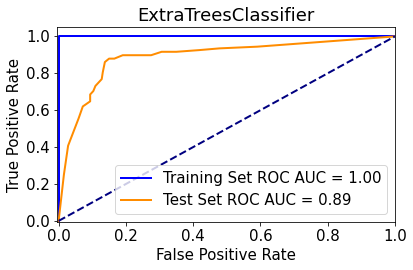

In [22]:
data = data_pros(X_res, y_res, X_test_ext, y_test_ext)
model = ExtraTreesClassifier(n_estimators=22, max_depth=65, max_features="log2", max_leaf_nodes=864).fit(data[0], data[1])
plt_roc_curve(model, data[0], data[1], data[2], data[3], "ExtraTreesClassifier")

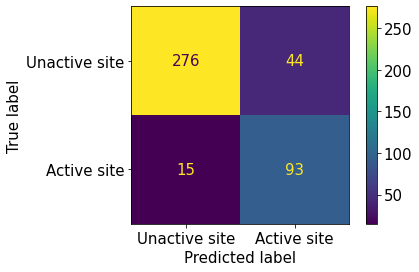

In [23]:
confusion_matrix_(model,data[2], data[3])